In [1]:
# !git clone https://github.com/Kemsekov/kemsekov_torch

704 


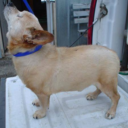

In [2]:
# load dataset for diffusion model to learn
import os
import PIL
import numpy as np
import torch
import torch.nn as nn
import random
from kemsekov_torch.train import split_dataset
import torchvision.transforms as T

# if some images have alpha we replace it with zeros
def process_alpha_image(img):
    # Open the image and convert to RGB from RGBA
    img_array = np.array(img)
    if len(img_array.shape)<3: return img
    if img_array.shape[-1]<4: 
        return img
    # Split into channels
    r, g, b, a = img_array[:, :, 0], img_array[:, :, 1], img_array[:, :, 2], img_array[:, :, 3]
    
    # Set RGB to 0 where alpha is 0
    r[a == 0] = 0
    g[a == 0] = 0
    b[a == 0] = 0
    
    # Create new RGB image array
    new_img_array = np.dstack((r, g, b)).astype(np.uint8)
    
    # Convert back to PIL Image and return
    return PIL.Image.fromarray(new_img_array)

class JustImagesDataset(torch.utils.data.Dataset):
    def __init__(self, images_folder, image_transform=None):
        super().__init__()
        allowed_formats = ['.png', '.jpg', '.jpeg', '.webp']
        self.images = []
        for root, _, files in os.walk(images_folder):
            self.images.extend(os.path.join(root, v) for v in files if any([v.endswith(f) for f in allowed_formats]))
        self.transform = nn.Identity() if image_transform is None else image_transform
        
    def __getitem__(self, index):
        im = self.images[index]
        im = PIL.Image.open(im)
        im = process_alpha_image(im)
        im = self.transform(im)
        return im, ''
    
    def __len__(self): return len(self.images)

# if some images are grayscale we map them to grayscale rgb
def add_dim(x):
    if len(x.shape)<3: return x[None,:][[0,0,0]]
    if x.shape[0]==1: return x[[0,0,0]]
    return x

IM_SIZE=128
transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(),
    T.Resize(IM_SIZE),
    T.RandomCrop((IM_SIZE,IM_SIZE)),
    T.Lambda(add_dim)
])

PATH_TO_IMAGES='/home/vlad/Documents/cat-dogs/'
dataset = JustImagesDataset(PATH_TO_IMAGES,transform)

batch_size=32
train_dataset,test_dataset,train_loader, test_loader = split_dataset(dataset,batch_size=batch_size,test_size=0.05)

ind = random.randint(0,len(dataset)-1)
# ind = 315
im,desc = dataset[ind]
print(ind,desc)
display(T.ToPILImage()(im))

In [3]:
# define diffusion model
from kemsekov_torch.diffusion import DiffusionUtils, sample
from kemsekov_torch.residual import Residual, ResidualBlock
from kemsekov_torch.attention import LinearSelfAttentionBlock, FlattenSpatialDimensions
from kemsekov_torch.rotary_emb import RotaryEmbInplace
from kemsekov_torch.positional_emb import ConcatPositionalEmbeddingPermute, PositionalEncodingPermute

class TimeContextEmbedding(torch.nn.Module):
    def __init__(self,in_channels,dimensions=2,max_timesteps=1024):
        """
        Layer that combines input x and timestep .
        
        in_channels: input channels
        
        dimensions: input/context spatial dimensions count
        
        max_timesteps: this parameter defines max timestep input value.
        """
        super().__init__()
        self.combine_x_time = [nn.Conv1d,nn.Conv2d,nn.Conv3d][dimensions-1](2*in_channels,in_channels,kernel_size=1)
        x=torch.randn((1,in_channels,max_timesteps,1))
        time = PositionalEncodingPermute(in_channels,freq=max_timesteps)(x)
        time = time[0].transpose(0,1)[...,0]
        self.time_emb = torch.nn.Parameter(time)
        
    def forward(self,x,timestep):
        """
        x: input of shape (B,C,...) where ... is spatial dimensions
        timestep: long tensor of shape (B). It is a timestep for each element in batch.
        """
        time = self.time_emb[timestep.cpu()].to(x.device)
        dims = list(time.shape)+[1]*(len(x.shape)-2)
        time=time.view(dims).expand_as(x)
        x_t = self.combine_x_time(torch.concat([x,time],1))
        return x_t

class DiffusionBlock(torch.nn.Module):
    """
    Diffusion unet block, that combines downsample/upsample operation and linear transformer blocks
    """
    def __init__(self,in_channels,out_channels,transformer_blocks = 0,residual_blocks=2,attn_heads=8,max_timesteps=64,normalization='batch',dimensions=2):
        super().__init__()
        mlp_dim=out_channels*2
        self.down = ResidualBlock(
            in_channels,
            out_channels,
            kernel_size=4,
            stride=2,
            dimensions=dimensions,
            normalization=normalization,
        )
        
        self.residual_blocks = Residual(
            [
                ResidualBlock(
                    out_channels,
                    [mlp_dim,out_channels],
                    kernel_size=3,
                    stride=1,
                    dimensions=dimensions,
                    normalization=normalization,
                )
                for i in range(residual_blocks)
            ]
        )
        
        self.embed_context_to_down = TimeContextEmbedding(out_channels,dimensions,max_timesteps)
        if transformer_blocks>0:
            # add self attention with rotary embedding optimized for pixel data
            self.sa = Residual([
                RotaryEmbInplace(out_channels,freqs_for='pixel'),
                FlattenSpatialDimensions([
                    LinearSelfAttentionBlock(out_channels,mlp_dim,attn_heads)
                    for i in range(transformer_blocks)
                ])
            ])
        else:
            self.sa = torch.nn.Identity()
        
    def forward(self,x,time):
        xt = self.down(x)
        xt = self.embed_context_to_down(xt,time)
        xt = self.sa(xt)
        xt = self.residual_blocks(xt)
        return xt
    
    def transpose(self):
        self.down = self.down.transpose()
        return self

class Diffusion(torch.nn.Module):
    def __init__(self, in_channels,max_timesteps=1024):
        super().__init__()
        
        common = dict(
            normalization=None,
            attn_heads = 16,
            dimensions = 2,
            max_timesteps=max_timesteps,
            residual_blocks=2,
        )
        
        scale = 1
        self.dimensions = common['dimensions']
        self.in_channels=in_channels
        self.down1 = DiffusionBlock(in_channels,64*scale,transformer_blocks=1,**common)
        self.down2 = DiffusionBlock(64*scale,128*scale,transformer_blocks=1,**common )
        self.down3 = DiffusionBlock(128*scale,256*scale,transformer_blocks=2,**common)
        self.down4 = DiffusionBlock(256*scale,512*scale,transformer_blocks=2,**common)
        
        self.up1 = DiffusionBlock(512*scale,256*scale,**common).transpose()
        self.merge_up1_down3 = nn.Conv2d(512*scale,256*scale,kernel_size=1)
        
        self.up2 = DiffusionBlock(256*scale,128*scale,**common).transpose()
        self.merge_up2_down2 = nn.Conv2d(256*scale,128*scale,kernel_size=1)
        
        self.up3 = DiffusionBlock(128*scale,64*scale,**common).transpose()
        self.merge_up3_down1 = nn.Conv2d(128*scale,64*scale,kernel_size=1)

        self.up4 = DiffusionBlock(64*scale,64*scale,**common).transpose()
        
        # to produce proper logits, combine model output that input
        self.final = nn.Sequential(
            [torch.nn.Conv1d,torch.nn.Conv2d,torch.nn.Conv3d][self.dimensions-1](64*scale,in_channels,kernel_size=1)
        )
    
    # x is batched single example with all noise levels
    # timestep is indices of noise levels for each sample is x
    # context_embedding is batched tensor with
    def forward(self,x, timestep : torch.LongTensor):
        """
        x: [batch,channels,width,height]
        
        timestep: [batch] tensor of type long
        """
        # if torch.isnan(x).any():
        #     print("x is nan")
        d1 = self.down1(x,timestep)
        
        # if torch.isnan(d1).any():
        #     print("d1 is nan")
            
        d2 = self.down2(d1,timestep)
        # if torch.isnan(d2).any():
        #     print("d2 is nan")
        d3 = self.down3(d2,timestep)
        d4 = self.down4(d3,timestep)
        
        u1 = self.up1(d4,timestep)
        u1 = self.merge_up1_down3(torch.concat([u1,d3],1))
        
        u2 = self.up2(u1,timestep)
        u2 = self.merge_up2_down2(torch.concat([u2,d2],1))
        
        u3 = self.up3(u2,timestep)
        u3 = self.merge_up3_down1(torch.concat([u3,d1],1))
        
        u4 = self.up4(u3,timestep)
        
        return self.final(u4)
    
in_channels = 3
# show example how to use it
s = torch.randn((2,in_channels,256,256)) # input noised images
timestep = torch.LongTensor([3,2]) #timestep indices
diff = Diffusion(in_channels,max_timesteps=512)
denoised = sample(diff,(1,in_channels,32,32),128)
pred_noise = diff(s,timestep)

In [4]:
# compute dataset images mean and std, so we can better rescale inputs to diffusion model
means = []
stds = []
for b in train_loader:
    im = b[0]
    dims = [-1,-2]
    mean = im.mean(dims,keepdim=True).mean(0)
    std = im.std(dims,keepdim=True).mean(0)
    means.append(mean)
    stds.append(std)

images_mean,images_std = torch.stack(means).mean(0),torch.stack(stds).mean(0)
images_mean.flatten(),images_std.flatten()

(tensor([0.4905, 0.4550, 0.4163]), tensor([0.2231, 0.2179, 0.2179]))

In [ ]:
from kemsekov_torch.train import *
import warnings
warnings.filterwarnings("ignore")

def r2_score(predictions: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Computes the R² (coefficient of determination) metric.

    Args:
        predictions (torch.Tensor): Predicted values tensor.
        targets (torch.Tensor): Actual target values tensor.

    Returns:
        float: R² score representing how well the predictions approximate the targets.
    """
    # Compute the total sum of squares (variance of the target)
    target_mean = torch.mean(targets)
    total_variance = torch.sum((targets - target_mean) ** 2)
    
    # Compute the residual sum of squares128
    residual_variance = torch.sum((targets - predictions) ** 2)
    
    # Calculate the R² score
    r2 = 1 - (residual_variance / total_variance)
    
    return r2.item()

timesteps=128
diff_util = DiffusionUtils(timesteps)

def compute_loss_and_metric(model,batch):
    image,desc = batch
    image=(image-images_mean.to(image.device))/images_std.to(image.device)
    time = torch.randint(0,timesteps-1,(len(image),))
    noised_samples,noise = diff_util.diffusion_forward(image,time)
    pred_noise = model(noised_samples,time)
    
    loss = torch.mean((pred_noise-noise)**2)
    r2 = r2_score(pred_noise,noise)
    return loss,{
        'r2':r2,
    }

# it works better without scheduler 
epochs = 1000
optim = torch.optim.AdamW(diff.parameters(),lr=1e-4)
sch = torch.optim.lr_scheduler.CosineAnnealingLR(optim,len(train_loader))

path = "runs/diffusion-cat-dog"
_ = train(
    diff,
    train_loader,
    test_loader,
    compute_loss_and_metric,
    path,
    os.path.join(path,'last'),
    scheduler=sch,
    optimizer=optim,
    gradient_clipping_max_norm=1,
    accelerate_args={
        'mixed_precision':'bf16',
        'dynamo_backend':'inductor', #painfully slow starts
        # 'gradient_accumulation_steps':4
    },
    save_on_metric_improve=['r2'],
    num_epochs=epochs,
)

Total model parameters 50.63 M
loaded training state from runs/diffusion-cat-dog/last/state
trying to capture model architecture...
Saved model architecture at runs/diffusion-cat-dog/model.pt. You can torch.load it and update it's weights with checkpoint

Epoch 58/1000


train 0: 100%|██████████| 596/596 [01:48<00:00,  5.51it/s, loss=0.1964, r2=0.8036]


+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.06993 | 0.07239 |
|  r2  | 0.9301  | 0.9276  |
+------+---------+---------+

Epoch 59/1000


train 0:   0%|          | 1/596 [00:41<6:52:19, 41.58s/it, loss=0.0584, r2=0.9417]W0616 19:30:01.141000 514716 torch/_dynamo/convert_frame.py:906] [6/8] torch._dynamo hit config.cache_size_limit (8)
W0616 19:30:01.141000 514716 torch/_dynamo/convert_frame.py:906] [6/8]    function: 'forward' (/home/vlad/Cardio/tmp/Image-Diffusion/kemsekov_torch/residual.py:30)
W0616 19:30:01.141000 514716 torch/_dynamo/convert_frame.py:906] [6/8]    last reason: 6/0: tensor 'L['x']' dtype mismatch. expected BFloat16, actual Float
W0616 19:30:01.141000 514716 torch/_dynamo/convert_frame.py:906] [6/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0616 19:30:01.141000 514716 torch/_dynamo/convert_frame.py:906] [6/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.
train 0: 100%|██████████| 596/596 [02:20<00:00,  4.23it/s, loss=0.0741, r2=0.9259]
W0616 19:31:37.075000 514716 torch/_dynamo/convert_frame.py:906] [4/8] torch._dynamo hit

+------+---------+---------+
|      |  Train  |  Test   |
+------+---------+---------+
| loss | 0.07094 | 0.07159 |
|  r2  | 0.9291  | 0.9284  |
+------+---------+---------+

Epoch 60/1000


train 0:   0%|          | 0/596 [00:00<?, ?it/s]

In [ ]:
diff = torch.jit.load(os.path.join(path,'model.pt'))
# diff = load_checkpoint(diff,path,-1)
diff = load_last_checkpoint(diff,path)
diff = diff.train().eval().float()

loading runs/diffusion-cat-dog/last/state


tensor(-0.1488) tensor(1.0131)


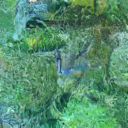

In [ ]:
inference_timesteps = 64
# torch.random.manual_seed(1)
pred = sample(
    diff,
    (1,in_channels,128,128),
    128,
    inference_timesteps,
    normalize_pred=False,
    regenerate_noise=False,
    rescale_generated_noise=False
).cpu()#.sigmoid()
print(pred.mean(),pred.std())
pred-=pred.min()
pred/=pred.max()
T.ToPILImage()(pred[0])